# Project Navigation Guidelines

In [20]:
'''
===================================================
Notebook naming convention for FindMeInside (FMI)
===================================================
Notebook name: [FMI] <Coord/Label> Alg - Exp<experiment_number>, Trial<trial_number>

===================================================
Folder/File naming convention
===================================================
# Folder categorised by Experiment (except Testing folder)
Folder name: Experiment<Experiment_number>

# Each Folder has N files.
# A file is either a 1)Unprocessed Dataset, 2)Processed Dataset, 3)Results dataset, 4) Notebook file
# Each experiment has N trials. (Adjustments to parameters/algorithm are made in each trial)
Files in folder will be named accordingly...

- Raw data point:             E<experiment_number>_Label/Location<location_identifier>_<date>v<version_number>
-- e.g. E1_LabelA_230320v1
- Raw data collection:        E<experiment_number>_All_Raw_<date>v<version_number>
-- e.g. E1_All_Raw_230320v1
- Processed data (if any):    E<experiment_number>_All_Proc_<date>v<version_number>
-- e.g. E1_All_Proc_230320v1
- Resampled data (if any):    E<experiment_number>_resampled_t<trial_number>
-- e.g. E1_resampled_t1
- Results data:               E<experiment_number>_<algorithm>_t<trial_number>_k<number_of_neighbours>
-- e.g. E1_KNN_t1_k37

===================================================
List of experiment(s) & description(s)
===================================================
>> Experiment 1 (Exp1) :11 Sensors {1, ..., 11} , 4 Location Labels {A,B,C,D}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 2 (Exp2) :11 Sensors {1, ..., 11} , 4 Location Coords {(x_A, y_A), ... (x_D, y_D)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 3 (Exp3) : 12 Sensors {0x1, ..., 0xC} , 12 Location Label {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 4 (Exp4) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 5 (Exp5) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Averaged 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

>> Experiment 6 (Exp6) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Resampled 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)
'''
None

# Trial Description

In [5]:
exp = 3  #experiment number
trial = 1 #trial number
'''
Trial 1 : 
Algorithms use Vote mechanic.
Resampling done within time period of 2s.
'''
None

# Core Libraries

In [6]:
import pandas as pd #from pandas import read_csv, pivot_table
import numpy as np
import math
import operator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing

import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Exploratory Data Analysis

# Prepare/Load Relevant Dataset

In [8]:
# Read csv file into dataframe.
csvfile = pd.read_csv('E'+str(exp)+'_All_Proc_230320v1.csv')
relDf = pd.DataFrame(csvfile)
# print(relDf)
relDf.columns = relDf.columns.str.strip() #strip unintended whitespaces

# print("Columns: ", relDf.columns)
relDf = relDf[['Date','Time', 'ID2', 'RSSI', 'Location']] #select relevant columns
# df = df.drop(columns=['Type', 'ID0', 'ID1', 'Sensor Data', 'Temperature', 'Humidity', 'Raw Data'])
print(relDf)

          Date       Time      ID2  RSSI Location
0      16/3/20   15:14:49   0x0001   192      1,1
1      16/3/20   15:14:49   0x0003   177      1,1
2      16/3/20   15:14:49   0x0004   179      1,1
3      16/3/20   15:14:50   0x0002   189      1,1
4      16/3/20   15:14:51   0x0008   177      1,1
...        ...        ...      ...   ...      ...
52882  19/3/20   15:48:51   0x0009   177    19,13
52883  19/3/20   15:48:51   0x0004   177    19,13
52884  19/3/20   15:48:51   0x0002   177    19,13
52885  19/3/20   15:48:51   0x000B   189    19,13
52886  19/3/20   15:48:51   0x0005   177    19,13

[52887 rows x 5 columns]


In [ ]:
# Resample/Reshape Dataset

In [10]:
# Preparation for Date/Time Differences
# ----------------------------------------
fileNameRS = 'E'+str(exp)+'_resampled_'+'T'+str(trial)+'.csv' #resampled file name
# Combine date and time to datetime
readings = relDf.copy()
readings['Datetime'] = pd.to_datetime(readings['Date'].apply(str)+' '+readings['Time']) #create new Datetime field
dateTime = readings['Datetime']
readings = readings.drop(columns=['Datetime'])
readings.insert(0, 'Datetime', dateTime)
readings = readings.drop(columns=['Date','Time'])
readings.tail()

from datetime import datetime as dt
earliestDate = readings.Datetime.dt.date.min()
print(readings.Datetime.dt.date.iloc[-1])
print(earliestDate - readings.Datetime.dt.date.iloc[-1])

# Function that expresses timestamps in seconds.
def time_to_sec(timeArray):
    timeSecArray = []
    for i in range(len(timeArray)):
        seconds = (timeArray[i].hour * 60 + timeArray[i].minute) * 60 + timeArray[i].second
        timeSecArray.append(seconds)
    return(timeSecArray)

# Function that calculates day difference between dates in seconds
def date_to_sec(dateArray):
    dateSecArray = []
    for i in range(len(dateArray)):
        dayDiff = dateArray[i] - earliestDate
        dateSecArray.append(dayDiff.total_seconds())
    print(i)
    return(dateSecArray)


readings['DateSec'] = date_to_sec(readings.Datetime.dt.date)
readings['TimeSec'] = time_to_sec(readings.Datetime.dt.time)
readings['DatetimeSec'] = readings['DateSec'] + readings['TimeSec']
readings = readings[['DatetimeSec', 'ID2', 'RSSI', 'Location']]
print(readings.head(15))

# pd.set_option('display.max_columns', 10)
# pd.set_option('display.min_rows', 50)
# pd.set_option('display.width', 500)

readings.DatetimeSec = (readings.DatetimeSec - readings.DatetimeSec.min()) // 2
time_diff_btw_rows = readings.DatetimeSec.diff().fillna(0)
print(time_diff_btw_rows)
time_diff_btw_rows -= (time_diff_btw_rows > 1) & (readings.DatetimeSec % 2 > 0)
readings.DatetimeSec -= (time_diff_btw_rows - 1).clip(lower=0).cumsum()
readings.ID2 = readings.ID2.transform(lambda hexadecimal: int(hexadecimal, 16))
resampled_readings = readings.groupby(["DatetimeSec", "Location", "ID2"]).mean().reset_index()
pivoted_readings = pd.pivot_table(resampled_readings, values="RSSI", columns=["ID2"], index=["DatetimeSec", "Location"]).fillna(0)

writeFile = True
if (writeFile == True):
    pivoted_readings.to_csv(fileNameRS)
    print("File "+fileNameRS +" has been written.")

pivoted_readings.head()

2020-03-19
-3 days, 0:00:00
52886
    DatetimeSec      ID2  RSSI Location
0       54889.0   0x0001   192      1,1
1       54889.0   0x0003   177      1,1
2       54889.0   0x0004   179      1,1
3       54890.0   0x0002   189      1,1
4       54891.0   0x0008   177      1,1
5       54891.0   0x0005   177      1,1
6       54891.0   0x0001   193      1,1
7       54891.0   0x000B   177      1,1
8       54891.0   0x0009   177      1,1
9       54891.0   0x0003   180      1,1
10      54892.0   0x0002   182      1,1
11      54893.0   0x0008   177      1,1
12      54893.0   0x0001   191      1,1
13      54893.0   0x0003   185      1,1
14      54893.0   0x000C   177      1,1
0        0.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
52882    0.0
52883    0.0
52884    0.0
52885    0.0
52886    0.0
Name: DatetimeSec, Length: 52887, dtype: float64
File E3_resampled_T1.csv has been written.


,ID2,1,2,3,4,5,6,7,8,9,10,11,12
DatetimeSec,Location,,,,,,,,,,,,
0.0,"1,1",192.0,189.0,177.0,179.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,"1,1",193.0,182.0,180.0,0.0,177.0,0.0,0.0,177.0,177.0,0.0,177.0,0.0
2.0,"1,1",191.0,191.0,185.0,184.0,177.0,177.0,0.0,177.0,0.0,177.0,0.0,177.0
3.0,"1,1",195.0,192.0,184.0,182.0,177.0,177.0,177.0,177.0,0.0,0.0,177.0,177.0
4.0,"1,1",194.0,193.0,184.0,187.0,0.0,0.0,177.0,178.0,0.0,0.0,0.0,177.0


In [14]:
resampledDS = pd.read_csv('E'+str(exp)+'_resampled_T'+str(trial)+'.csv')
tempSeries = resampledDS['Location']
resampledDS = resampledDS.drop(columns=['Location', 'DatetimeSec'])
resampledDS["Location"] = tempSeries
resampledDS.head()
lastIndex = len(resampledDS)
numCol = len(resampledDS.columns)

ips_data = resampledDS.iloc[:lastIndex, :numCol-1]
# print(ips_data)
ips_labels = resampledDS.iloc[:lastIndex, numCol-1:]
# print(ips_labels)


# #dataset.iloc[rowrange, columnrange]
X = ips_data.to_numpy()
y = ips_labels.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True,test_size=0.3) 
y_train = y_train.reshape(len(y_train),)

k_value_rootN = math.ceil(math.sqrt(len(X_train)))
print("estimated k value: ", k_value_rootN)
print("X_test: ", X_test)
print("y_test: ", y_test)

estimated k value:  63
X_test:  [[185. 183.   0. ...   0. 183. 177.]
 [183. 187. 190. ... 177. 180. 183.]
 [184. 191. 189. ... 177. 181.   0.]
 ...
 [182. 193. 190. ... 177. 177. 182.]
 [184. 192. 191. ...   0. 177. 187.]
 [177. 177.   0. ... 179. 195. 193.]]
y_test:  [['7,1']
 ['1,13']
 ['7,13']
 ...
 ['1,7']
 ['1,7']
 ['19,7']]


# Parameter Optimisation

In [15]:
# k_range = list(range(1, 31))
# print("k_range: ", k_range)

# classifier = KNeighborsClassifier()

# param_grid = dict(n_neighbors=k_range)
# print("param_grid: ", param_grid)

# grid = GridSearchCV(classifier, param_grid, cv=10, scoring='accuracy')

# grid.fit(X,y)
# print("best_estimator: ", grid.best_estimator_)

# KNN Algorithm

In [17]:
n_samples = 20

#Function calculates euclidean distance between two n-dimensional data instances 
def euclideanDistance(instance1, instance2):
    #handles if instances are lists or tuples:
    instance1 = np.array(instance1) 
    instance2 = np.array(instance2)
    
    '''
    https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html
    uses 2-norm frobenius norm and returns euclidean distance
    '''
    return np.linalg.norm(instance1 - instance2) #euclidean distance

In [18]:
#Function finds nearest neighbours; nearest -> smallest euclidean distance
def get_neighbors(training_set, 
                  labels, 
                  test_instance, 
                  k, 
                  distance=euclideanDistance):
    """
    get_neighbors calculates a list of the k nearest neighbors
    of an instance 'test_instance'.
    The list neighbors contains 3-tuples with  
    (index, dist, label)
    where
    index    is the index from the training_set, 
    dist     is the distance between the test_instance and the 
             instance training_set[index]
    distance is a reference to a function used to calculate the 
             distances
    """
    distances = [] #empty distance array
    
    #calculates euclidean distance between test_instance and ALL other instances in training_set
    for index in range(len(training_set)):
        dist = euclideanDistance(test_instance, training_set[index])
        distances.append((training_set[index], dist, labels[index]))
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    return neighbors # The list neighbors contains 3-tuples with (index, dist, label)

In [19]:
# TEST OUTPUT

outArray = []
for i in range(n_samples):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_rootN, 
                              distance=euclideanDistance)
#     print(i,
#           X_test[i],
#           y_test[i],
#           neighbors)
    
    outArray.append([i,
          X_test[i],
          y_test[i],
          neighbors])

out_df = pd.DataFrame(outArray, columns=['i', 'X_test', 'y_test', 'neighbours'])
out_df.head()
# out_df.tail()

,i,X_test,y_test,neighbours
0,0,"[185.0, 183.0, 0.0, 196.0, 185.0, 182.0, 183.0...","[7,1]","[([177.0, 190.0, 0.0, 184.0, 194.0, 182.0, 180..."
1,1,"[183.0, 187.0, 190.0, 180.0, 0.0, 0.0, 178.0, ...","[1,13]","[([183.0, 187.0, 190.0, 178.0, 0.0, 0.0, 179.0..."
2,2,"[184.0, 191.0, 189.0, 0.0, 0.0, 196.0, 179.0, ...","[7,13]","[([181.0, 191.0, 184.0, 0.0, 0.0, 180.0, 0.0, ..."
3,3,"[177.0, 189.0, 186.0, 177.0, 188.0, 198.0, 0.0...","[7,13]","[([177.0, 188.0, 193.0, 177.0, 185.0, 194.0, 0..."
4,4,"[194.0, 193.0, 184.0, 183.0, 0.0, 177.0, 178.0...","[1,1]","[([194.0, 193.0, 184.0, 183.0, 0.0, 177.0, 177..."


In [20]:
from collections import Counter

#Function enables voting mechanic in KNN for Classification according to majority class vote
def vote(neighbors):
    class_counter = Counter() #A Counter is a dict subclass for counting hashable objects. 
    for neighbor in neighbors:
        class_counter[neighbor[2]] += 1 #neighbor[2] -> label for neighbor(s)
    return class_counter.most_common(1)[0][0]

In [99]:
k_value_knn = k_value_rootN
for i in range(5):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    print("index: ", i, 
          ", result of vote: ", vote(neighbors), 
          ", label: ", y_train[i], 
          ", data: ", X_train[i])

index:  0 , result of vote:  7,7 , label:  13,7 , data:  [  0. 178.   0. 185. 194.   0. 190. 193. 185. 183. 193. 185.]
index:  1 , result of vote:  1,13 , label:  19,13 , data:  [  0. 178. 179.   0. 177.   0. 177. 179. 180.   0. 192. 198.]
index:  2 , result of vote:  7,7 , label:  13,7 , data:  [  0. 177.   0. 178. 187. 181. 187. 191. 188.   0. 189. 182.]
index:  3 , result of vote:  7,13 , label:  7,1 , data:  [177. 177.   0. 193. 191. 177. 179. 178. 180. 177. 183. 180.]
index:  4 , result of vote:  1,7 , label:  1,7 , data:  [177. 196. 193. 177.   0. 177. 177. 178.   0. 177. 185. 183.]


In [100]:
#Function returns vote 'probability' - i.e. distribution/percentage majority vote
def vote_prob(neighbors):
    class_counter = Counter() # Counter object - https://docs.python.org/2/library/collections.html
    for neighbor in neighbors:
        class_counter[neighbor[2]] += 1 #add to count of target (class)
        
    # aggregates into tuples ~ zip(*iterables), 
    # Return a list of the n most common elements and their counts from the most common to the least.    
    labels, votes = zip(*class_counter.most_common()) #returns list of sorted most common [labels], [votes]
    #print("L|V: ", labels, votes)
    #print("Class Counter: ", class_counter.most_common)
    winner = class_counter.most_common(1)[0][0]       #majority label
    votes4winner = class_counter.most_common(1)[0][1] #majority vote count
    return winner, votes4winner/sum(votes)            #returns majority label, majority proportion

In [101]:
writeKNN = True
fileNameKNN = 'E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(k_value_knn)+'.csv'
resultsKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'vote_result', 'vote_prob', 'label', 'prediction'])

indexArray = []
dataArray = []
voteArray = []
probArray = []
labelArray = []
predArray = []
for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    indexArray.append(i)
    dataArray.append(X_test[i])
    voteArray.append(vote(neighbors))
    probArray.append(vote_prob(neighbors))
    labelArray.append(y_test[i][0])
    predArray.append("CORRECT" if (vote(neighbors) == y_test[i]) else "WRONG")
#     print("index: ", i, 
#           ", result of vote: ", vote(neighbors), 
#           ", vote_prob: ", vote_prob(neighbors), 
#           ", label: ", y_test[i], "prediction: "
#         "CORRECT" if (vote(neighbors) == y_test[i]) else "WRONG"
#           ", data: ", X_test[i])

resultsKNN['index'] = indexArray
resultsKNN['data'] = dataArray
resultsKNN['vote_result'] = voteArray
resultsKNN['vote_prob'] = probArray
resultsKNN['label'] = labelArray 
resultsKNN['prediction'] = predArray

if (writeKNN == True):
    resultsKNN.to_csv(fileNameKNN, index=False)
    print("File "+fileNameKNN+" has been written.")
resultsKNN.head(20)

File E3_KNN_T1_k63.csv has been written.


,index,data,vote_result,vote_prob,label,prediction
0,0,"[185.0, 183.0, 0.0, 196.0, 185.0, 182.0, 183.0...","7,7","(7,7, 0.36507936507936506)","7,1",WRONG
1,1,"[183.0, 187.0, 190.0, 180.0, 0.0, 0.0, 178.0, ...","1,13","(1,13, 0.7142857142857143)","1,13",CORRECT
2,2,"[184.0, 191.0, 189.0, 0.0, 0.0, 196.0, 179.0, ...","7,7","(7,7, 0.2222222222222222)","7,13",WRONG
3,3,"[177.0, 189.0, 186.0, 177.0, 188.0, 198.0, 0.0...","7,13","(7,13, 0.7936507936507936)","7,13",CORRECT
4,4,"[194.0, 193.0, 184.0, 183.0, 0.0, 177.0, 178.0...","1,7","(1,7, 0.36507936507936506)","1,1",WRONG
5,5,"[183.0, 187.0, 0.0, 0.0, 180.0, 0.0, 0.0, 0.0,...","1,13","(1,13, 0.4126984126984127)","1,13",CORRECT
6,6,"[0.0, 0.0, 178.0, 191.0, 177.0, 180.0, 192.0, ...","13,1","(13,1, 0.5873015873015873)","13,1",CORRECT
7,7,"[0.0, 180.0, 177.0, 185.0, 192.0, 0.0, 191.0, ...","13,1","(13,1, 0.3333333333333333)","13,7",WRONG
8,8,"[0.0, 177.0, 177.0, 184.0, 192.0, 180.0, 192.0...","13,1","(13,1, 0.42857142857142855)","13,7",WRONG
9,9,"[183.0, 194.0, 0.0, 177.0, 0.0, 187.0, 177.0, ...","7,7","(7,7, 0.3492063492063492)","1,7",WRONG


# Rank (Harmonic) Weighted KNN

In [76]:
#Function for weighted KNN voting mechanic; harmonic weights based on ranking of datapoint (vote += 1/rank)
def vote_harmonic_weights(neighbors, all_results=True):
    class_counter = Counter()
    number_of_neighbors = len(neighbors)
    for index in range(number_of_neighbors):
#         print("Index: ", index)
        class_counter[neighbors[index][2]]
#         print("Location: ", neighbors[index][2])
        class_counter[neighbors[index][2]] += ( 1/(index+1) ) #add (1/ neighbour_rank) for each vote, index+1 = neighbour_rank
    labels, votes = zip(*class_counter.most_common())
    #print(labels, votes)
    winner = class_counter.most_common(1)[0][0]
    votes4winner = class_counter.most_common(1)[0][1]
    if all_results:
        total = sum(class_counter.values(), 0.0)
        for key in class_counter:
             class_counter[key] /= total #returns vote proportion for key ("class") in class_counter
        return winner, class_counter.most_common()
    else:
        return winner, votes4winner / sum(votes)

In [102]:
k_value_rwknn = k_value_rootN
writeRWKNN = True
fileNameRWKNN = 'E'+str(exp)+'_RWKNN_'+'T'+str(trial)+'_k'+str(k_value_rwknn)+'.csv'
resultsRWKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'label', 'vote_result', 'prediction'])

indexArray = []
dataArray = []
labelArray = []
voteArray = []
predArray = []

for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_rwknn, 
                              distance=euclideanDistance)
    voteResult = (vote_harmonic_weights(neighbors,all_results=True))

    indexArray.append(i)
    dataArray.append(X_test[i])
    labelArray.append(y_test[i])
    voteArray.append(voteResult)
    predArray.append("CORRECT" if (voteResult[0] == y_test[i]) else "WRONG")
    
resultsRWKNN['index'] = indexArray
resultsRWKNN['data'] = dataArray
resultsRWKNN['label'] = labelArray
resultsRWKNN['vote_result'] = voteArray
resultsRWKNN['prediction'] = predArray

if (writeRWKNN == True):
    resultsRWKNN.to_csv(fileNameRWKNN, index=False)
    print("File "+fileNameRWKNN+" has been written.")
resultsRWKNN


File E3_RWKNN_T1_k63.csv has been written.


,index,data,label,vote_result,prediction
0,0,"[185.0, 183.0, 0.0, 196.0, 185.0, 182.0, 183.0...","[7,1]","(7,7, [(7,7, 0.41698609590673974), (1,13, 0.27...",WRONG
1,1,"[183.0, 187.0, 190.0, 180.0, 0.0, 0.0, 178.0, ...","[1,13]","(1,13, [(1,13, 0.9095908522762258), (1,1, 0.04...",CORRECT
2,2,"[184.0, 191.0, 189.0, 0.0, 0.0, 196.0, 179.0, ...","[7,13]","(7,7, [(7,7, 0.4429316075158199), (7,13, 0.272...",WRONG
3,3,"[177.0, 189.0, 186.0, 177.0, 188.0, 198.0, 0.0...","[7,13]","(7,13, [(7,13, 0.8999947770889732), (13,13, 0....",CORRECT
4,4,"[194.0, 193.0, 184.0, 183.0, 0.0, 177.0, 178.0...","[1,1]","(1,1, [(1,1, 0.5483738003873674), (1,7, 0.2428...",CORRECT
...,...,...,...,...,...
1690,1690,"[0.0, 181.0, 177.0, 185.0, 190.0, 183.0, 191.0...","[13,7]","(13,7, [(13,7, 0.5181603678591378), (19,7, 0.1...",CORRECT
1691,1691,"[0.0, 179.0, 177.0, 184.0, 194.0, 182.0, 192.0...","[13,7]","(13,7, [(13,7, 0.5181603678591379), (19,7, 0.1...",CORRECT
1692,1692,"[182.0, 193.0, 190.0, 177.0, 0.0, 177.0, 0.0, ...","[1,7]","(1,7, [(1,7, 0.5694638212017866), (7,13, 0.176...",CORRECT
1693,1693,"[184.0, 192.0, 191.0, 177.0, 183.0, 187.0, 178...","[1,7]","(1,7, [(1,7, 0.8517383069087073), (7,13, 0.148...",CORRECT


# Distance Weighted KNN

In [78]:
#Function for distance weighted KNN voting mechanic; weight based on euclidean distance (vote += 1/distance)
def vote_distance_weights(neighbors, all_results=True):
    debug = False
    class_counter = Counter()
    number_of_neighbors = len(neighbors)
    for index in range(number_of_neighbors):
        dist = neighbors[index][1]
        label = neighbors[index][2]
        if (debug == True):
            print("Neighbour record: Label is ", label, "with distance ", dist)
            print("Existing count for ", label, "is ", class_counter[label[0]])
            print("Adding count by ", (1 / (1 if dist == 0 else dist)))
        class_counter[label[0]] += (1 / (1 if dist == 0 else dist)) #sensitivity of distance weight can be adjusted here.
        
        
    labels, votes = zip(*class_counter.most_common())
    #print(labels, votes)
    winner = class_counter.most_common(1)[0][0]
    votes4winner = class_counter.most_common(1)[0][1]
    if (debug == True):
        print("COUNTER: ", class_counter)
        print("----------------------------------------------------")
        print("winner: ", winner)
        print("votes: ", votes4winner)
    
    if all_results:
        total = sum(class_counter.values(), 0.0)
        
        for key in class_counter:
            class_counter[key] /= total
        if (debug == True):
            print("total votes: ", total)
            print("AFTER NORMALISING: ", class_counter)
        return winner, class_counter.most_common()
    else:
        return winner, votes4winner / sum(votes)

In [103]:
k_value_dwknn = k_value_rootN
testRange = 200
for i in range(testRange):
    neighbors = get_neighbors(X_test, 
                              y_test, 
                              X_train[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
    res = vote_distance_weights(neighbors, all_results=True)
    
    print("index: ", i, 
      ", result of vote: ", res,
    ",label: ", y_test[i], 
    ",prediction: ",
    "CORRECT" if ( res[0] == y_test[i]) else "WRONG")
    print("\n\n")

index:  0 , result of vote:  ('13,7', [('13,7', 0.38938072610603947), ('13,1', 0.35360568300651946), ('19,7', 0.09173061525713976), ('13,13', 0.08764045397947229), ('19,1', 0.05975101541143321), ('19,13', 0.01316334947124654), ('7,1', 0.00472815676814925)]) ,label:  ['7,1'] ,prediction:  WRONG



index:  1 , result of vote:  ('19,13', [('19,13', 0.5499902219343008), ('13,13', 0.1821342235628055), ('13,7', 0.12766241703751774), ('1,7', 0.058492117000296065), ('19,7', 0.05470823744370148), ('1,13', 0.013510662059831577), ('7,1', 0.013502120961546696)]) ,label:  ['1,13'] ,prediction:  WRONG



index:  2 , result of vote:  ('13,7', [('13,7', 0.5798172935790232), ('13,13', 0.17284512256198495), ('19,7', 0.08474641275683337), ('19,13', 0.05236192912386158), ('1,7', 0.04491025164809339), ('13,1', 0.026082625370722628), ('19,1', 0.013236210721655291), ('7,1', 0.013003330977034468), ('7,13', 0.006587704293514368), ('7,7', 0.006409118967276709)]) ,label:  ['7,13'] ,prediction:  WRONG



index:  

index:  31 , result of vote:  ('13,7', [('13,7', 0.398728468584956), ('13,1', 0.29440680021594473), ('19,7', 0.11609043829204581), ('19,1', 0.07926744248163994), ('19,13', 0.05938852593811087), ('7,1', 0.04526516750959867), ('13,13', 0.00685315697770402)]) ,label:  ['13,13'] ,prediction:  WRONG



index:  32 , result of vote:  ('19,13', [('19,13', 0.39710508007116957), ('13,13', 0.2306779203946185), ('13,7', 0.20615108369906804), ('19,7', 0.13554637096411054), ('7,1', 0.007694115088893101), ('7,7', 0.007641062354524064), ('13,1', 0.007597485602035173), ('1,7', 0.007586881825580818)]) ,label:  ['1,1'] ,prediction:  WRONG



index:  33 , result of vote:  ('13,13', [('13,13', 0.5070039121229765), ('19,13', 0.19734280655137906), ('13,7', 0.1747068917915087), ('7,7', 0.0480493908524087), ('7,1', 0.030672392550055935), ('7,13', 0.017846846020849776), ('1,1', 0.01632415250867908), ('19,7', 0.00805360760214237)]) ,label:  ['13,13'] ,prediction:  CORRECT



index:  34 , result of vote:  ('7,13'

index:  64 , result of vote:  ('7,13', [('7,13', 0.5002695877169869), ('1,7', 0.18109159898868682), ('7,7', 0.17325575259477383), ('7,1', 0.04775700430506687), ('13,13', 0.04320446047059279), ('1,1', 0.02510154336734085), ('13,7', 0.022638688999075902), ('19,7', 0.0066813635574760315)]) ,label:  ['13,1'] ,prediction:  WRONG



index:  65 , result of vote:  ('19,7', [('19,7', 0.33041171348900295), ('19,1', 0.20703864992521231), ('19,13', 0.2032789096647965), ('13,1', 0.17322921439526823), ('13,13', 0.048636629395528826), ('7,1', 0.025464656284711815), ('13,7', 0.011940226845479244)]) ,label:  ['7,1'] ,prediction:  WRONG



index:  66 , result of vote:  ('1,13', [('1,13', 0.4146758901032264), ('13,1', 0.2175965846187843), ('7,1', 0.1944164523980705), ('1,1', 0.04868242676864222), ('19,1', 0.04449119109204003), ('7,7', 0.03518742346354091), ('19,13', 0.01516466147290756), ('1,7', 0.01494263812899469), ('13,7', 0.014842731953793344)]) ,label:  ['1,13'] ,prediction:  CORRECT



index:  67 ,

index:  98 , result of vote:  ('7,13', [('7,13', 0.6566735477449869), ('1,7', 0.09955553932026338), ('7,7', 0.08531565038297664), ('7,1', 0.0713187955416352), ('13,13', 0.0516582037488789), ('1,1', 0.019030644075215288), ('13,7', 0.01644761918604373)]) ,label:  ['7,7'] ,prediction:  WRONG



index:  99 , result of vote:  ('19,1', [('19,1', 0.6438376357233007), ('19,7', 0.14372068892623296), ('19,13', 0.12183153160013757), ('13,1', 0.057025357543477616), ('13,13', 0.024559423106392923), ('13,7', 0.009025363100458258)]) ,label:  ['19,1'] ,prediction:  CORRECT



index:  100 , result of vote:  ('13,13', [('13,13', 0.699903566605169), ('19,13', 0.21155120081619946), ('13,7', 0.01896527384861189), ('1,7', 0.01844227368038004), ('7,13', 0.014336304291766005), ('7,7', 0.013916289739298112), ('7,1', 0.009209328369213246), ('13,1', 0.004719791949117299), ('19,7', 0.004623723318644219), ('1,1', 0.0043322473816008586)]) ,label:  ['19,7'] ,prediction:  WRONG



index:  101 , result of vote:  ('1,7

index:  133 , result of vote:  ('1,1', [('1,1', 0.9895163733513719), ('1,13', 0.007732967064057729), ('7,13', 0.0011157002980476274), ('7,7', 0.0008203889839916425), ('13,13', 0.0008145703025312533)]) ,label:  ['13,13'] ,prediction:  WRONG



index:  134 , result of vote:  ('1,1', [('1,1', 0.7038351897151935), ('7,1', 0.09607186981050889), ('7,7', 0.08524772338138266), ('1,13', 0.03924068873968234), ('1,7', 0.03805041014289555), ('7,13', 0.012757982030157346), ('19,7', 0.012168410324260484), ('13,13', 0.006486163418952662), ('13,1', 0.006141562436966445)]) ,label:  ['13,1'] ,prediction:  WRONG



index:  135 , result of vote:  ('7,7', [('7,7', 0.5934396461909185), ('7,13', 0.16355565938299177), ('1,7', 0.11949026367588168), ('7,1', 0.04941268990203677), ('13,13', 0.026548377154923433), ('1,1', 0.022905117388222162), ('13,7', 0.019152315451980546), ('19,7', 0.005495930853045173)]) ,label:  ['1,7'] ,prediction:  WRONG



index:  136 , result of vote:  ('7,7', [('7,7', 0.472764126806943),

index:  159 , result of vote:  ('1,1', [('1,1', 0.9743597437950117), ('1,7', 0.00685891411894788), ('7,7', 0.005988936951362203), ('1,13', 0.005477814575083639), ('7,1', 0.0045821692152532055), ('7,13', 0.0013758557832112906), ('13,13', 0.001356565561130204)]) ,label:  ['13,13'] ,prediction:  WRONG



index:  160 , result of vote:  ('13,13', [('13,13', 0.22955270616681683), ('7,7', 0.15411429723107553), ('1,13', 0.1375084832557853), ('1,7', 0.1306288769851163), ('7,1', 0.09294922750414268), ('7,13', 0.08359980513828132), ('13,7', 0.06179411669780769), ('19,13', 0.04809106210815588), ('19,7', 0.03042781494060685), ('13,1', 0.016000993113982228), ('1,1', 0.015332616858229323)]) ,label:  ['19,1'] ,prediction:  WRONG



index:  161 , result of vote:  ('1,7', [('1,7', 0.7061135626721725), ('7,7', 0.10586510927734435), ('7,13', 0.08799148913912866), ('7,1', 0.04830984855141993), ('19,7', 0.04667119659902827), ('13,13', 0.005048793760906293)]) ,label:  ['1,1'] ,prediction:  WRONG



index:  1

index:  191 , result of vote:  ('19,13', [('19,13', 0.4029575760115744), ('13,13', 0.2254169130273992), ('13,7', 0.19590330989907526), ('19,7', 0.1444173242137129), ('7,1', 0.00789234865595187), ('7,7', 0.007808449980115197), ('1,7', 0.0078049720688939984), ('13,1', 0.007799106143277194)]) ,label:  ['19,13'] ,prediction:  CORRECT



index:  192 , result of vote:  ('13,13', [('13,13', 0.5639356992249799), ('1,13', 0.11869323984551866), ('1,7', 0.10273133797978987), ('7,13', 0.08966800669413011), ('7,7', 0.04336544358493787), ('7,1', 0.03546226739605882), ('1,1', 0.03439684836060903), ('13,7', 0.01174715691397587)]) ,label:  ['19,13'] ,prediction:  WRONG



index:  193 , result of vote:  ('13,7', [('13,7', 0.46075548642998165), ('7,1', 0.2441067951154611), ('19,7', 0.09260448585954696), ('13,13', 0.04479397916557863), ('13,1', 0.03924634726528728), ('1,1', 0.035451352392940415), ('1,7', 0.030703975763390935), ('7,7', 0.018096900649602107), ('1,13', 0.017218585430063056), ('7,13', 0.01702

In [104]:
writeDWKNN = True
fileNameDWKNN = 'E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(k_value_knn)+'.csv'
resultsDWKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'label', 'vote_result', 'prediction'])

indexArray = []
dataArray = []
labelArray = []
voteArray = []
predArray = []

# need to normalise distance!!!!

for i in range(len(X_test)):
    neighbors = get_neighbors(X_test, 
                              y_test, 
                              X_train[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
    voteRes = vote_distance_weights(neighbors, all_results=True)
#     print(voteRes)
    indexArray.append(i)
    dataArray.append(X_test[i])
    labelArray.append(y_test[i])
    voteArray.append(voteRes[0])
    predArray.append("CORRECT" if (voteRes[0] == y_test[i]) else "WRONG")

#     print("index: ", i, ", result of vote: ", vote_distance_weights(neighbors,
#                                                       all_results=True),
#         ",label: ", y_test[i], 
#         ",prediction: ",
#         "CORRECT" if ( vote_distance_weights(neighbors,
#                                 all_results=True)[0] == y_test[i]) else "WRONG")
    
resultsDWKNN['index'] = indexArray
resultsDWKNN['data'] = dataArray
resultsDWKNN['label'] = labelArray
resultsDWKNN['vote_result'] = voteArray
resultsDWKNN['prediction'] = predArray


if (writeDWKNN == True):
    resultsDWKNN.to_csv(fileNameDWKNN, index=False)
    print("File "+fileNameDWKNN+" has been written.")
resultsDWKNN



File E3_DWKNN_T1_k63.csv has been written.


,index,data,label,vote_result,prediction
0,0,"[185.0, 183.0, 0.0, 196.0, 185.0, 182.0, 183.0...","[7,1]","13,7",WRONG
1,1,"[183.0, 187.0, 190.0, 180.0, 0.0, 0.0, 178.0, ...","[1,13]","19,13",WRONG
2,2,"[184.0, 191.0, 189.0, 0.0, 0.0, 196.0, 179.0, ...","[7,13]","13,7",WRONG
3,3,"[177.0, 189.0, 186.0, 177.0, 188.0, 198.0, 0.0...","[7,13]","7,1",WRONG
4,4,"[194.0, 193.0, 184.0, 183.0, 0.0, 177.0, 178.0...","[1,1]","1,7",WRONG
...,...,...,...,...,...
1690,1690,"[0.0, 181.0, 177.0, 185.0, 190.0, 183.0, 191.0...","[13,7]","1,1",WRONG
1691,1691,"[0.0, 179.0, 177.0, 184.0, 194.0, 182.0, 192.0...","[13,7]","1,7",WRONG
1692,1692,"[182.0, 193.0, 190.0, 177.0, 0.0, 177.0, 0.0, ...","[1,7]","1,7",CORRECT
1693,1693,"[184.0, 192.0, 191.0, 177.0, 183.0, 187.0, 178...","[1,7]","1,13",WRONG


# Data Analysis via Visualisation

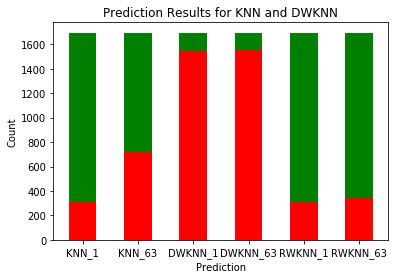

<Figure size 2160x2160 with 0 Axes>

In [106]:

KNN_kcomp1 = pd.read_csv('E3_KNN_T1_k1.csv')
#count number of CORRECT/ WRONG.
KNN_kcomp1_results = KNN_kcomp1.groupby('prediction').count().data
count_correct_KNN_kcomp1 = (KNN_kcomp1_results.CORRECT)
count_wrong_KNN_kcomp1 = (KNN_kcomp1_results.WRONG)

DWKNN_kcomp1 = pd.read_csv('E3_DWKNN_T1_k1.csv')
#count number of CORRECT/ WRONG.
DWKNN_kcomp1_results = DWKNN_kcomp1.groupby('prediction').count().data
count_correct_DWKNN_kcomp1 = (DWKNN_kcomp1_results.CORRECT)
count_wrong_DWKNN_kcomp1 = (DWKNN_kcomp1_results.WRONG)

RWKNN_kcomp1 = pd.read_csv('E3_RWKNN_T1_k1.csv')
#count number of CORRECT/ WRONG.
RWKNN_kcomp1_results = RWKNN_kcomp1.groupby('prediction').count().data
count_correct_RWKNN_kcomp1 = (RWKNN_kcomp1_results.CORRECT)
count_wrong_RWKNN_kcomp1 = (RWKNN_kcomp1_results.WRONG)

KNN_kcomp2 = pd.read_csv('E3_KNN_T1_k63.csv')
#count number of CORRECT/ WRONG.
KNN_kcomp2_results = KNN_kcomp2.groupby('prediction').count().data
count_correct_KNN_kcomp2 = (KNN_kcomp2_results.CORRECT)
count_wrong_KNN_kcomp2 = (KNN_kcomp2_results.WRONG)

RWKNN_kcomp2 = pd.read_csv('E3_RWKNN_T1_k63.csv')
#count number of CORRECT/ WRONG.
RWKNN_kcomp2_results = RWKNN_kcomp2.groupby('prediction').count().data
count_correct_RWKNN_kcomp2 = (RWKNN_kcomp2_results.CORRECT)
count_wrong_RWKNN_kcomp2 = (RWKNN_kcomp2_results.WRONG)

DWKNN_kcomp2 = pd.read_csv('E3_DWKNN_T1_k63.csv')
#count number of CORRECT/ WRONG.
DWKNN_kcomp2_results = DWKNN_kcomp2.groupby('prediction').count().data
count_correct_DWKNN_kcomp2 = (DWKNN_kcomp2_results.CORRECT)
count_wrong_DWKNN_kcomp2 = (DWKNN_kcomp2_results.WRONG)


# create plot
n_groups = 1 # number of groups
fig, ax = plt.subplots()
index = np.arange(n_groups) # x location for groups
bar_width = 1

#first bar - rects1+rects2
rects1 = plt.bar(index, count_correct_KNN_kcomp1, bar_width, bottom = count_wrong_KNN_kcomp1, 
#                  label='KNN_1_CORRECT', 
                 color = 'g')
rects2 = plt.bar(index, count_wrong_KNN_kcomp1, bar_width, 
                 color = 'r')

rects3 = plt.bar(index + 2*bar_width, count_correct_KNN_kcomp2, bar_width, bottom = count_wrong_KNN_kcomp2, 
                 color = 'g')
rects4 = plt.bar(index + 2*bar_width, count_wrong_KNN_kcomp2, bar_width, 
                 color = 'r')

rects5 = plt.bar(index + 4*bar_width, count_correct_DWKNN_kcomp1, bar_width, bottom = count_wrong_DWKNN_kcomp1, 
                 color = 'g')
rects6 = plt.bar(index + 4*bar_width, count_wrong_DWKNN_kcomp1, bar_width,
                 color = 'r')

rects7 = plt.bar(index + 6*bar_width, count_correct_DWKNN_kcomp2, bar_width, bottom = count_wrong_DWKNN_kcomp2,
                 color = 'g')
rects8 = plt.bar(index + 6*bar_width, count_wrong_DWKNN_kcomp2, bar_width,
                 color = 'r')

rects9 = plt.bar(index + 8*bar_width, count_correct_RWKNN_kcomp1, bar_width, bottom = count_wrong_RWKNN_kcomp1,  
                 color = 'g')
rects10 = plt.bar(index + 8*bar_width, count_wrong_RWKNN_kcomp1, bar_width, 
                 color = 'r')

rects9 = plt.bar(index + 10*bar_width, count_correct_RWKNN_kcomp2, bar_width, bottom = count_wrong_RWKNN_kcomp2,  
                 color = 'g')
rects10 = plt.bar(index + 10*bar_width, count_wrong_RWKNN_kcomp2, bar_width, 
                 color = 'r')

plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Prediction Results for KNN and DWKNN')
plt.xticks([0,2*bar_width, 4*bar_width, 6*bar_width, 8*bar_width, 10*bar_width], ["KNN_1", "KNN_63", "DWKNN_1", "DWKNN_63", "RWKNN_1", "RWKNN_63"])
# plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.figure(figsize=(30,30))
plt.show()

In [115]:
KNNsummary1 = KNN_kcomp1.groupby('prediction').count().data
RWKNNsummary1 = RWKNN_kcomp1.groupby('prediction').count().data
DWKNNsummary1 = DWKNN_kcomp1.groupby('prediction').count().data

KNNsummary2 = KNN_kcomp2.groupby('prediction').count().data
RWKNNsummary2 = RWKNN_kcomp2.groupby('prediction').count().data
DWKNNsummary2 = DWKNN_kcomp2.groupby('prediction').count().data

print("--------------")
print("Summary")
print("--------------")
print("KNNcomp1: \n", KNNsummary1)
print("Accuracy: ", KNN_kcomp1_results.CORRECT / 
      (KNN_kcomp1_results.CORRECT + KNN_kcomp1_results.WRONG))
print("\nKNNcomp2: \n", KNNsummary2)
print("Accuracy: ", KNN_kcomp2_results.CORRECT / 
      (KNN_kcomp2_results.CORRECT + KNN_kcomp2_results.WRONG))
print("--------------")
print("RWKNNcomp1: \n", RWKNNsummary1)
print("Accuracy: ", RWKNN_kcomp1_results.CORRECT / 
      (RWKNN_kcomp1_results.CORRECT + RWKNN_kcomp1_results.WRONG))
print("\nRWKNNcomp2: \n", RWKNNsummary2)
print("Accuracy: ", RWKNN_kcomp2_results.CORRECT / 
      (RWKNN_kcomp2_results.CORRECT + RWKNN_kcomp2_results.WRONG))
print("--------------")
print("DWKNNcomp1: \n", DWKNNsummary1)
print("Accuracy: ", DWKNN_kcomp1_results.CORRECT / 
      (DWKNN_kcomp1_results.CORRECT + DWKNN_kcomp1_results.WRONG))
print("\nDWKNNcomp2: \n", DWKNNsummary2)
print("Accuracy: ", DWKNN_kcomp2_results.CORRECT / 
      (DWKNN_kcomp2_results.CORRECT + DWKNN_kcomp2_results.WRONG))

--------------
Summary
--------------
KNNcomp1: 
 prediction
CORRECT    1384
WRONG       311
Name: data, dtype: int64
Accuracy:  0.8165191740412979

KNNcomp2: 
 prediction
CORRECT    975
WRONG      720
Name: data, dtype: int64
Accuracy:  0.5752212389380531
--------------
RWKNNcomp1: 
 prediction
CORRECT    1384
WRONG       311
Name: data, dtype: int64
Accuracy:  0.8165191740412979

RWKNNcomp2: 
 prediction
CORRECT    1356
WRONG       339
Name: data, dtype: int64
Accuracy:  0.8
--------------
DWKNNcomp1: 
 prediction
CORRECT     152
WRONG      1543
Name: data, dtype: int64
Accuracy:  0.08967551622418879

DWKNNcomp2: 
 prediction
CORRECT     144
WRONG      1551
Name: data, dtype: int64
Accuracy:  0.08495575221238938


In [187]:
import re 
# x = "This is a sentence. (once a day) [twice a day]"
# re.sub("[\(\[].*?[\)\]]", "", x)
# 'This is a sentence.  
# re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", x)
# markroxor the first regex groups '(' and ']' into group 
# 1(by surrounding it with parentheses) and ')' and ']' into group 2.,
# matching these groups and all characters that come in between the two groups.
# s[s.find("(")+1:s.find(")")]

KNNtest1 = pd.read_csv('E3_KNN_T1_k1.csv')
voteResArray = KNNtest1['vote_result']
# print(KNNtest1.head())
KNNcomp1_errorSeries = []
for record in KNNtest1.values:
    voteRes = record[2]
    label = record[4]
    voteTuple = tuple(map(int, voteRes.split(',')))
    labelTuple = tuple(map(int, label.split(',')))
    EDerror = euclideanDistance(voteTuple, labelTuple)
#     print(euclideanDistance(voteTuple, labelTuple))
    KNNcomp1_errorSeries.append(EDerror)

KNNtest2 = pd.read_csv('E3_KNN_T1_k63.csv')
voteResArray = KNNtest2['vote_result']
KNNcomp2_errorSeries = []
for record in KNNtest2.values:
    voteRes = record[2]
    label = record[4]
    voteTuple = tuple(map(int, voteRes.split(',')))
    labelTuple = tuple(map(int, label.split(',')))
    EDerror = euclideanDistance(voteTuple, labelTuple)
#     print(euclideanDistance(voteTuple, labelTuple))
    KNNcomp2_errorSeries.append(EDerror)

RWKNNtest1 = pd.read_csv('E3_RWKNN_T1_k1.csv')
voteResArray = RWKNNtest1['vote_result']
# print(RWKNNtest1.head())
RWKNNcomp1_errorSeries = []
for record in RWKNNtest1.values:
    voteList = record[3][2:]
    voteRes = voteList[:voteList.find("'")]
#     print("VoteRES: ", voteRes)
    labelList = record[2][2:]
    label = labelList[:labelList.find("'")]
#     print("labelRES: ", label)
    voteTuple = tuple(map(int, voteRes.split(',')))
    labelTuple = tuple(map(int, label.split(',')))
    EDerror = euclideanDistance(voteTuple, labelTuple)
#     print(euclideanDistance(voteTuple, labelTuple))
    RWKNNcomp1_errorSeries.append(EDerror)
    
RWKNNtest2 = pd.read_csv('E3_RWKNN_T1_k63.csv')
voteResArray = RWKNNtest2['vote_result']
# print(RWKNNtest2.head())
RWKNNcomp2_errorSeries = []
for record in RWKNNtest2.values:
    voteList = record[3][2:]
    voteRes = voteList[:voteList.find("'")]
#     print("VoteRES: ", voteRes)
    labelList = record[2][2:]
    label = labelList[:labelList.find("'")]
#     print("labelRES: ", label)
    voteTuple = tuple(map(int, voteRes.split(',')))
    labelTuple = tuple(map(int, label.split(',')))
    EDerror = euclideanDistance(voteTuple, labelTuple)
#     print(euclideanDistance(voteTuple, labelTuple))
    RWKNNcomp2_errorSeries.append(EDerror)
    
DWKNNtest1 = pd.read_csv('E3_DWKNN_T1_k1.csv')
voteResArray = DWKNNtest1['vote_result']
DWKNNcomp1_errorSeries = []
for record in DWKNNtest1.values:
    voteRes = record[3]
    labelList = record[2][2:]
    label = labelList[:labelList.find("'")]
    voteTuple = tuple(map(int, voteRes.split(',')))
    labelTuple = tuple(map(int, label.split(',')))
    EDerror = euclideanDistance(voteTuple, labelTuple)
#     print(euclideanDistance(voteTuple, labelTuple))
    DWKNNcomp1_errorSeries.append(EDerror)   
    
DWKNNtest2 = pd.read_csv('E3_DWKNN_T1_k63.csv')
voteResArray = DWKNNtest2['vote_result']
DWKNNcomp2_errorSeries = []
for record in DWKNNtest2.values:
    voteRes = record[3]
    labelList = record[2][2:]
    label = labelList[:labelList.find("'")]
    voteTuple = tuple(map(int, voteRes.split(',')))
    labelTuple = tuple(map(int, label.split(',')))
    EDerror = euclideanDistance(voteTuple, labelTuple)
#     print(euclideanDistance(voteTuple, labelTuple))
    DWKNNcomp2_errorSeries.append(EDerror) 

    
# =================== #
errorDataframe = pd.DataFrame(index = range(0,len(KNNtest1)))
errorDataframe['KNNcomp1'] = KNNcomp1_errorSeries
errorDataframe['KNNcomp2'] = KNNcomp2_errorSeries
errorDataframe['RWKNNcomp1'] = RWKNNcomp1_errorSeries
errorDataframe['RWKNNcomp2'] = RWKNNcomp2_errorSeries
errorDataframe['DWKNNcomp1'] = RWKNNcomp1_errorSeries
errorDataframe['DWKNNcomp2'] = RWKNNcomp1_errorSeries
errorDataframe


   index                                               data     label  \
0      0  [185. 183.   0. 196. 185. 182. 183.   0.   0. ...   ['7,1']   
1      1  [183. 187. 190. 180.   0.   0. 178.   0.   0. ...  ['1,13']   
2      2  [184. 191. 189.   0.   0. 196. 179.   0. 185. ...  ['7,13']   
3      3  [177. 189. 186. 177. 188. 198.   0. 177. 187. ...  ['7,13']   
4      4  [194. 193. 184. 183.   0. 177. 178. 177. 177. ...   ['1,1']   

  vote_result prediction  
0        13,7      WRONG  
1       19,13      WRONG  
2        13,7      WRONG  
3         7,1      WRONG  
4         1,7      WRONG  
   index                                               data     label  \
0      0  [185. 183.   0. 196. 185. 182. 183.   0.   0. ...   ['7,1']   
1      1  [183. 187. 190. 180.   0.   0. 178.   0.   0. ...  ['1,13']   
2      2  [184. 191. 189.   0.   0. 196. 179.   0. 185. ...  ['7,13']   
3      3  [177. 189. 186. 177. 188. 198.   0. 177. 187. ...  ['7,13']   
4      4  [194. 193. 184. 183.   0

,KNNcomp1,KNNcomp2,RWKNNcomp1,RWKNNcomp2,DWKNNcomp1,DWKNNcomp2
0,6.0,6.000000,6.0,6.0,6.0,6.0
1,0.0,0.000000,0.0,0.0,0.0,0.0
2,6.0,6.000000,6.0,6.0,6.0,6.0
3,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,6.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1690,0.0,8.485281,0.0,0.0,0.0,0.0
1691,0.0,8.485281,0.0,0.0,0.0,0.0
1692,0.0,0.000000,0.0,0.0,0.0,0.0
1693,0.0,8.485281,0.0,0.0,0.0,0.0


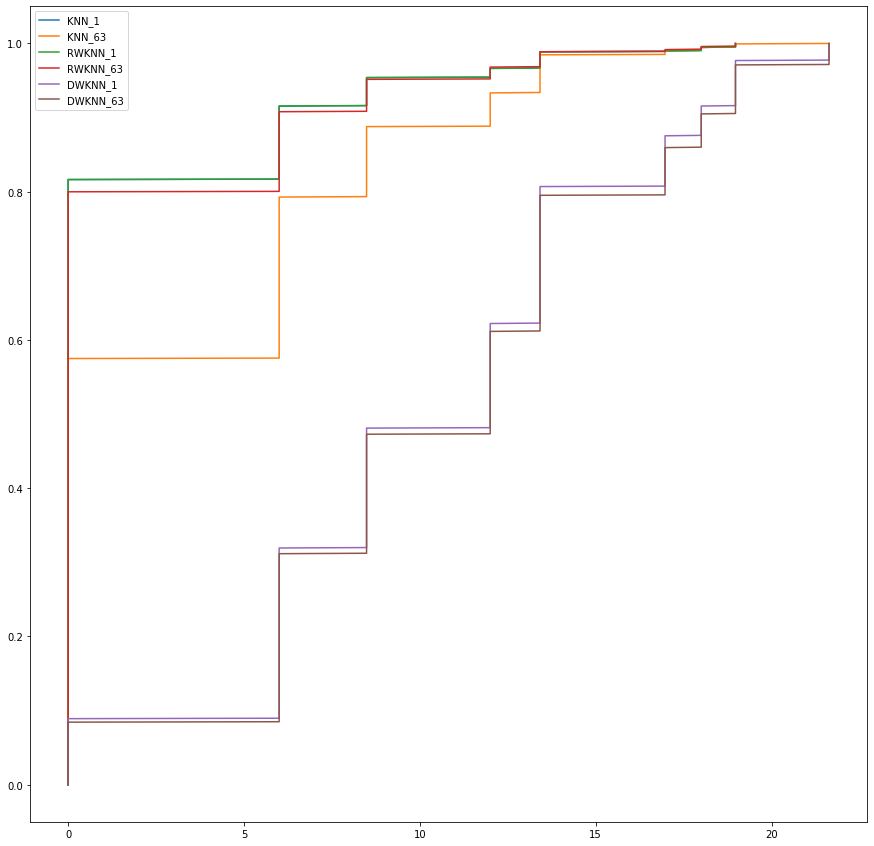

In [194]:
fig= plt.figure(figsize=(15,15))

knn_kcomp1_error = np.sort(KNNcomp1_errorSeries)
cdf = np.arange(0,len(knn_kcomp1_error),step=1)/(len(knn_kcomp1_error)-1)
plt.plot(knn_kcomp1_error,cdf, label = "KNN_1")

knn_kcomp2_error = np.sort(KNNcomp2_errorSeries)
cdf = np.arange(0,len(knn_kcomp2_error),step=1)/(len(knn_kcomp2_error)-1)
plt.plot(knn_kcomp2_error,cdf, label = "KNN_63")

rwknn_kcomp1_error = np.sort(RWKNNcomp1_errorSeries)
cdf = np.arange(0,len(rwknn_kcomp1_error),step=1)/(len(rwknn_kcomp1_error)-1)
plt.plot(rwknn_kcomp1_error,cdf, label = "RWKNN_1")

rwknn_kcomp2_error = np.sort(RWKNNcomp2_errorSeries)
cdf = np.arange(0,len(rwknn_kcomp2_error),step=1)/(len(rwknn_kcomp2_error)-1)
plt.plot(rwknn_kcomp2_error,cdf, label = "RWKNN_63")

dwknn_kcomp1_error = np.sort(DWKNNcomp1_errorSeries)
cdf = np.arange(0,len(rwknn_kcomp1_error),step=1)/(len(rwknn_kcomp1_error)-1)
plt.plot(dwknn_kcomp1_error,cdf, label = "DWKNN_1")

dwknn_kcomp2_error = np.sort(DWKNNcomp2_errorSeries)
cdf = np.arange(0,len(dwknn_kcomp2_error),step=1)/(len(dwknn_kcomp2_error)-1)
plt.plot(dwknn_kcomp2_error,cdf, label = "DWKNN_63")

plt.legend()
plt.show()